# Recovery analysis for the model

This notebook performs the recovery analysis reported in the supplement.

Basic idea is to take fitted parameters, simulate model, then fit that simulated data and compare the recovered parameters to the original parameters.

In [ ]:
from src.models.env import WordsconsinEnv
from src.models.feature_rl import *
from src.models.utils import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", context="paper")
import pandas as pd
from tqdm.notebook import tqdm
import pingouin as pg

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def get_sub_block_structure(sub_strat_df):
    ss_gb_df = sub_strat_df.groupby("block")[
        ["corr_rule_numeric", "max_trial_within_block"]
    ].mean()
    sub_block_structure = []

    for i in range(0, 32):
        block_dict = {}
        block_dict["rule"] = int(ss_gb_df.iloc[i]["corr_rule_numeric"] + 1)
        block_dict["blockLen"] = int(ss_gb_df.iloc[i]["max_trial_within_block"] + 1)

        # need to make a tuple of all the item_idx0 and item_idx1 for the block
        block_dict["words"] = list(
            zip(
                sub_strat_df[sub_strat_df["block"] == i + 1]["item_rule_idx0"],
                sub_strat_df[sub_strat_df["block"] == i + 1]["item_rule_idx1"],
            )
        )
        sub_block_structure.append(block_dict)
    return sub_block_structure


def generate_env_for_recovery(sub_block_structure=None):
    env1 = WordsconsinEnv(8, [6, 7, 7, 8], 2, 2, 600)

    env1.reset()
    if sub_block_structure is not None:
        env1.block_structure = sub_block_structure
        env1.provided_sub_block_structure = True
    corr_rule_numeric = [[x["rule"] - 1] * x["blockLen"] for x in env1.block_structure]
    corr_rule_numeric = [item for sublist in corr_rule_numeric for item in sublist]

    block_id = [[i] * x["blockLen"] for i, x in enumerate(env1.block_structure)]
    block_id = [item for sublist in block_id for item in sublist]

    trial_within_block = [np.arange(0, x["blockLen"]) for x in env1.block_structure]
    trial_within_block = [item for sublist in trial_within_block for item in sublist]

    trial_num = np.arange(0, len(corr_rule_numeric))
    word_list = [x["words"] for x in env1.block_structure]
    word_list = [item for sublist in word_list for item in sublist]
    return env1, corr_rule_numeric, block_id, trial_within_block, trial_num, word_list

In [ ]:
# load in some parameter fits:
fit_df = pd.read_csv(
    "../../data/processed/exp1/DecayFeatureRL_no_resp_st_results.csv"
)
strat_df = pd.read_csv(
    "../../data/processed/exp1/DecayFeatureRL_strat_data_rpe.csv"
)
strat_df = strat_df[strat_df["condition"] == 1].reset_index(drop=True)

fit_df = fit_df[fit_df["subid"].isin(strat_df["subid"])].reset_index(drop=True)
fit_df = fit_df.sort_values(by="subid").reset_index(drop=True)

In [4]:
# need a function that takes in the sub_strat_df and then overwrites the block_structure in env with the block_structure from the sub_strat_df
sub_strat_df = strat_df[strat_df["subid"] == strat_df["subid"].unique()[0]].reset_index(
    drop=True
)
sub_block_structure = get_sub_block_structure(sub_strat_df)

In [5]:
sim_data_1env = pd.DataFrame()

for subid in tqdm(strat_df["subid"].unique()):
    sub_block_structure = get_sub_block_structure(
        strat_df[strat_df["subid"] == subid].reset_index(drop=True)
    )
    env1, corr_rule_numeric, block_id, trial_within_block, trial_num, word_list = (
        generate_env_for_recovery(sub_block_structure)
    )
    # jitter_eta = np.random.uniform(0, 1)
    # jitter_beta = np.random.normal(3.40, 1)
    # jitter_decay = np.random.uniform(0, 1)
    # # jitter_kappa = np.random.uniform(0, 1)
    # jitter_resp_st = 0
    # eta, beta, decay, resp_st = fit_df[fit_df["subid"] == subid].iloc[0][
    #     ["eta", "beta", "decay", "resp_st"]
    # ]
    eta, beta, decay = fit_df[fit_df["subid"] == subid].iloc[0][
        ["eta", "beta", "decay"]
    ]
    # print(0.01)

    model = DecayFeatureRL(eta, beta, decay, 0)
    # model = DecayFeatureRLalphaMod(jitter_eta,jitter_beta,jitter_decay,jitter_kappa,1)
    model.sim(env1, 224)

    # grab out the Ws from the model for when uncertainty is high (above 0.05)
    word_list_idx0 = [word[0] for word in word_list]
    word_list_idx1 = [word[1] for word in word_list]
    inv_word_list_idx0 = [1 - x for x in word_list_idx0]
    inv_word_list_idx1 = [1 - x for x in word_list_idx1]
    sim_df = {
        "block": block_id,
        "trial": trial_num,
        "corr_rule_numeric": corr_rule_numeric,
        "trial_within_block": trial_within_block,
        "resp_numeric": model.actions,
        "reward": model.sim_rewards,
        "item_rule_idx0": word_list_idx0,
        "item_rule_idx1": word_list_idx1,
        "inv_item_rule_idx0": inv_word_list_idx0,
        "inv_item_rule_idx1": inv_word_list_idx1,
    }
    sim_df = pd.DataFrame(sim_df)
    sim_df["resp_numeric"] = sim_df["resp_numeric"].astype(int)
    sim_df["eta"] = eta
    sim_df["beta"] = beta
    sim_df["decay"] = decay
    sim_df["resp_st"] = 0
    sim_df["subid"] = f"{subid}"
    # label column run by block where each run is 8 blocks
    sim_df["run"] = (sim_df["block"] // 8) + 1

    sim_data_1env = pd.concat([sim_data_1env, sim_df])

  0%|          | 0/66 [00:00<?, ?it/s]

In [6]:
sim_data_1env = sim_data_1env.reset_index(drop=True)
sim_data_1env

,block,trial,corr_rule_numeric,trial_within_block,resp_numeric,reward,item_rule_idx0,item_rule_idx1,inv_item_rule_idx0,inv_item_rule_idx1,eta,beta,decay,resp_st,subid,run
0,0,0,2,0,1,0.0,1,1,0,0,0.636722,2.508470,0.516420,0,53987712fdf99b68e3a45021,1
1,0,1,2,1,1,0.0,0,1,1,0,0.636722,2.508470,0.516420,0,53987712fdf99b68e3a45021,1
2,0,2,2,2,1,1.0,1,0,0,1,0.636722,2.508470,0.516420,0,53987712fdf99b68e3a45021,1
3,0,3,2,3,1,1.0,1,0,0,1,0.636722,2.508470,0.516420,0,53987712fdf99b68e3a45021,1
4,0,4,2,4,0,1.0,1,1,0,0,0.636722,2.508470,0.516420,0,53987712fdf99b68e3a45021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14779,31,219,1,2,1,0.0,0,1,1,0,0.405648,2.054791,0.664857,0,65f3bf636afc5f3102e7f2fd,4
14780,31,220,1,3,0,1.0,0,1,1,0,0.405648,2.054791,0.664857,0,65f3bf636afc5f3102e7f2fd,4
14781,31,221,1,4,1,0.0,0,1,1,0,0.405648,2.054791,0.664857,0,65f3bf636afc5f3102e7f2fd,4
14782,31,222,1,5,1,1.0,1,1,0,0,0.405648,2.054791,0.664857,0,65f3bf636afc5f3102e7f2fd,4


In [7]:
sim_data_1env.subid.nunique()

66

In [8]:
sim_data_1env.corr_rule_numeric.value_counts()

2    3696
0    3696
1    3696
3    3696
Name: corr_rule_numeric, dtype: int64

In [9]:
sim_data_1env.groupby("subid")["reward"].mean().describe()

count    66.000000
mean      0.619048
std       0.049424
min       0.486607
25%       0.589286
50%       0.609375
75%       0.651786
max       0.718750
Name: reward, dtype: float64

In [10]:
gb_df = strat_df.groupby(["subid", "trial_within_block"])["points"].mean().reset_index()
gb_df["reward"] = gb_df["points"]
gb_df["real_or_sim"] = "real"
# sns.pointplot(x="trial_within_block", y="reward", data=gb_df)
gb_sim_df = (
    sim_data_1env.groupby(["subid", "trial_within_block"])["reward"]
    .mean()
    .reset_index()
)
gb_sim_df["real_or_sim"] = "sim"
gb_df = pd.concat([gb_df, gb_sim_df])
gb_df.real_or_sim.value_counts()

real    528
sim     528
Name: real_or_sim, dtype: int64

<Axes: xlabel='trial_within_block', ylabel='reward'>

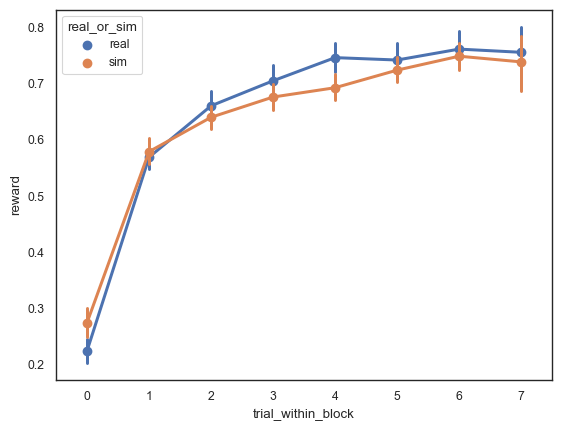

In [11]:
sns.pointplot(x="trial_within_block", y="reward", data=gb_df, hue="real_or_sim")

In [ ]:
sim_data = process_sim_data(sim_data_1env)
sim_data.to_csv(
    "../../data/processed/exp1/simulated_data.csv",
    index=False,
)

In [13]:
sim_data.groupby(["subid", "rel_subj_boundary"])["reward"].mean().reset_index()

,subid,rel_subj_boundary,reward
0,53987712fdf99b68e3a45021,-5,1.000000
1,53987712fdf99b68e3a45021,-4,1.000000
2,53987712fdf99b68e3a45021,-3,0.833333
3,53987712fdf99b68e3a45021,-2,0.931034
4,53987712fdf99b68e3a45021,-1,0.793103
...,...,...,...
1007,65f3bf636afc5f3102e7f2fd,4,0.750000
1008,65f3bf636afc5f3102e7f2fd,5,1.000000
1009,65f3bf636afc5f3102e7f2fd,6,1.000000
1010,65f3bf636afc5f3102e7f2fd,7,1.000000


In [14]:
sim_data["resp_numeric"]

0        1
1        1
2        1
3        1
4        0
        ..
14779    1
14780    0
14781    1
14782    1
14783    0
Name: resp_numeric, Length: 14784, dtype: int64

<Axes: xlabel='rel_subj_boundary', ylabel='reward'>

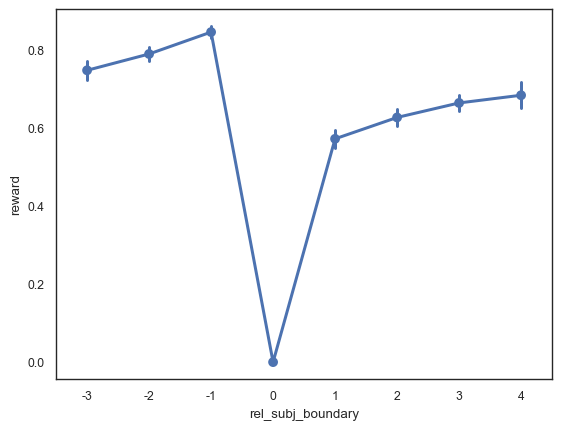

In [15]:
sns.pointplot(x="rel_subj_boundary", y="reward", data=sim_data, order=range(-3, 5))

In [16]:
sim_data.columns

Index(['block', 'trial', 'corr_rule_numeric', 'trial_within_block',
       'resp_numeric', 'reward', 'item_rule_idx0', 'item_rule_idx1',
       'inv_item_rule_idx0', 'inv_item_rule_idx1', 'eta', 'beta', 'decay',
       'resp_st', 'subid', 'run', 'points', 'max_trial_within_block',
       'avg_acc_last_2', 'good_block', 'prev_good_block', 'obj_boundary',
       'subj_boundary', 'rel_obj_boundary', 'rel_subj_boundary'],
      dtype='object')

In [ ]:
# # fit the RL model to the simulated data to extract best fitting parameters
# !python -m writ_tools.rl.fit_rl -i ../../data/processed/exp1/simulated_data.csv -o ../../simulated/exp1 -m decayfeaturerl -r

## Load in the fit_df for both experiments and both results


In [ ]:
exp1_fit_df = pd.read_csv(
    "../../data/processed/exp1/DecayFeatureRL_no_resp_st_results.csv"
)
exp2_fit_df = pd.read_csv(
    "../../data/processed/exp2/DecayFeatureRL_no_resp_st_results.csv"
)
exp1_fit_df = exp1_fit_df.sort_values(by="subid").reset_index(drop=True)
exp2_fit_df = exp2_fit_df.sort_values(by="subid").reset_index(drop=True)
exp1_fit_df["exp"] = "exp1"
exp2_fit_df["exp"] = "exp2"
all_fit_df = pd.concat([exp1_fit_df, exp2_fit_df])

In [ ]:
sim_fit_df_exp1 = pd.read_csv(
    "../../data/simulated/exp1/DecayFeatureRL_no_resp_st_results.csv"
)
sim_fit_df_exp2 = pd.read_csv(
    "../../data/simulated/exp2/DecayFeatureRL_no_resp_st_results.csv"
)
sim_fit_df_exp1 = sim_fit_df_exp1.sort_values(by="subid").reset_index(drop=True)
sim_fit_df_exp2 = sim_fit_df_exp2.sort_values(by="subid").reset_index(drop=True)
sim_fit_df_exp1["exp"] = "exp1"
sim_fit_df_exp2["exp"] = "exp2"
all_sim_fit_df = pd.concat([sim_fit_df_exp1, sim_fit_df_exp2])
all_sim_fit_df

all_fit_df = pd.merge(
    all_fit_df, all_sim_fit_df, on=["subid", "exp"], suffixes=["_init", "_sim"]
)
all_fit_df

,subid,eta_init,beta_init,decay_init,resp_st_init,loglik_init,aic_init,model_init,exp,eta_sim,beta_sim,decay_sim,resp_st_sim,loglik_sim,aic_sim,model_sim
0,53987712fdf99b68e3a45021,0.636722,2.508470,0.516420,0.0,-100.247889,206.495778,DecayFeatureRL_no_resp_st,exp1,0.597782,2.694433,0.409588,0.0,-103.563832,213.127665,DecayFeatureRL_no_resp_st
1,55885869fdf99b4020ba0b64,0.316209,0.979888,0.636028,0.0,-149.678986,305.357972,DecayFeatureRL_no_resp_st,exp1,0.233999,1.703010,0.771670,0.0,-149.025664,304.051327,DecayFeatureRL_no_resp_st
2,55914b15fdf99b1e5e44e714,0.250694,2.803349,0.497620,0.0,-121.790861,249.581722,DecayFeatureRL_no_resp_st,exp1,0.351546,3.422579,0.245319,0.0,-100.961685,207.923370,DecayFeatureRL_no_resp_st
3,55bc1119fdf99b5693f3ec47,0.456194,1.558500,0.264195,0.0,-140.300811,286.601622,DecayFeatureRL_no_resp_st,exp1,0.266293,2.330243,0.199423,0.0,-130.478332,266.956665,DecayFeatureRL_no_resp_st
4,5685850c333cbd000d4e042f,0.538673,2.234024,0.547080,0.0,-112.899709,231.799418,DecayFeatureRL_no_resp_st,exp1,0.514748,2.028938,0.722041,0.0,-115.844256,237.688511,DecayFeatureRL_no_resp_st
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,671fed5db8abfa3e54928141,0.634969,2.186086,0.518803,0.0,-107.510585,221.021169,DecayFeatureRL_no_resp_st,exp2,0.837512,1.626061,0.438375,0.0,-124.419582,254.839163,DecayFeatureRL_no_resp_st
201,67227b6a95c02df067984f28,0.587585,2.255213,0.208075,0.0,-112.369519,230.739038,DecayFeatureRL_no_resp_st,exp2,0.610243,3.012291,0.318275,0.0,-95.592765,197.185530,DecayFeatureRL_no_resp_st
202,67239f4f85318190f3ee173a,0.575050,2.320011,0.322211,0.0,-108.241464,222.482927,DecayFeatureRL_no_resp_st,exp2,0.660107,2.339848,0.343018,0.0,-108.977872,223.955745,DecayFeatureRL_no_resp_st
203,6723e1f006b4c75bc2b1f43c,0.438105,2.120037,0.503862,0.0,-124.768330,255.536661,DecayFeatureRL_no_resp_st,exp2,0.363544,2.586417,0.482400,0.0,-117.686194,241.372389,DecayFeatureRL_no_resp_st


In [20]:
exp1_all_fit = all_fit_df[all_fit_df["exp"] == "exp1"]
exp2_all_fit = all_fit_df[all_fit_df["exp"] == "exp2"]
for exp in ["exp1", "exp2"]:
    print(exp)
    for param in ["eta", "beta", "decay"]:
        print(param)
        exp_fit = exp1_all_fit if exp == "exp1" else exp2_all_fit
        print(
            pg.corr(
                exp_fit[f"{param}_sim"],
                exp_fit[f"{param}_init"],
                method="spearman",
            )
        )
        print("\n")

exp1
eta
           n         r         CI95%         p-val  power
spearman  66  0.819852  [0.72, 0.89]  3.815709e-17    1.0


beta
           n         r         CI95%         p-val  power
spearman  66  0.756268  [0.63, 0.84]  2.098009e-13    1.0


decay
           n         r         CI95%     p-val     power
spearman  66  0.520718  [0.32, 0.68]  0.000007  0.996001


exp2
eta
            n         r         CI95%         p-val  power
spearman  139  0.756361  [0.67, 0.82]  5.011471e-27    1.0


beta
            n         r        CI95%         p-val  power
spearman  139  0.725363  [0.64, 0.8]  5.633305e-24    1.0


decay
            n         r         CI95%         p-val  power
spearman  139  0.721618  [0.63, 0.79]  1.233660e-23    1.0




In [21]:
# First melt to separate init and sim values
melted_df = all_fit_df.melt(
    id_vars=["subid", "exp"],
    value_vars=[
        "eta_init",
        "beta_init",
        "decay_init",
        "eta_sim",
        "beta_sim",
        "decay_sim",
    ],
    var_name="param",
    value_name="value",
)

# Create new columns by splitting the param column
melted_df["param_type"] = (
    melted_df["param"].str.split("_").str[1]
)  # gets 'init' or 'sim'
melted_df["param_name"] = (
    melted_df["param"].str.split("_").str[0]
)  # gets 'eta', 'beta', or 'decay'

# Pivot to get init and sim as separate columns
final_df = melted_df.pivot_table(
    index=["subid", "exp", "param_name"], columns="param_type", values="value"
).reset_index()

# Optionally rename columns for clarity
final_df.columns.name = None
final_df

,subid,exp,param_name,init,sim
0,53987712fdf99b68e3a45021,exp1,beta,2.508470,2.694433
1,53987712fdf99b68e3a45021,exp1,decay,0.516420,0.409588
2,53987712fdf99b68e3a45021,exp1,eta,0.636722,0.597782
3,55885869fdf99b4020ba0b64,exp1,beta,0.979888,1.703010
4,55885869fdf99b4020ba0b64,exp1,decay,0.636028,0.771670
...,...,...,...,...,...
610,6723e1f006b4c75bc2b1f43c,exp2,decay,0.503862,0.482400
611,6723e1f006b4c75bc2b1f43c,exp2,eta,0.438105,0.363544
612,67240ea419a9065a4284a609,exp2,beta,4.675193,5.159774
613,67240ea419a9065a4284a609,exp2,decay,0.822534,0.915532


/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


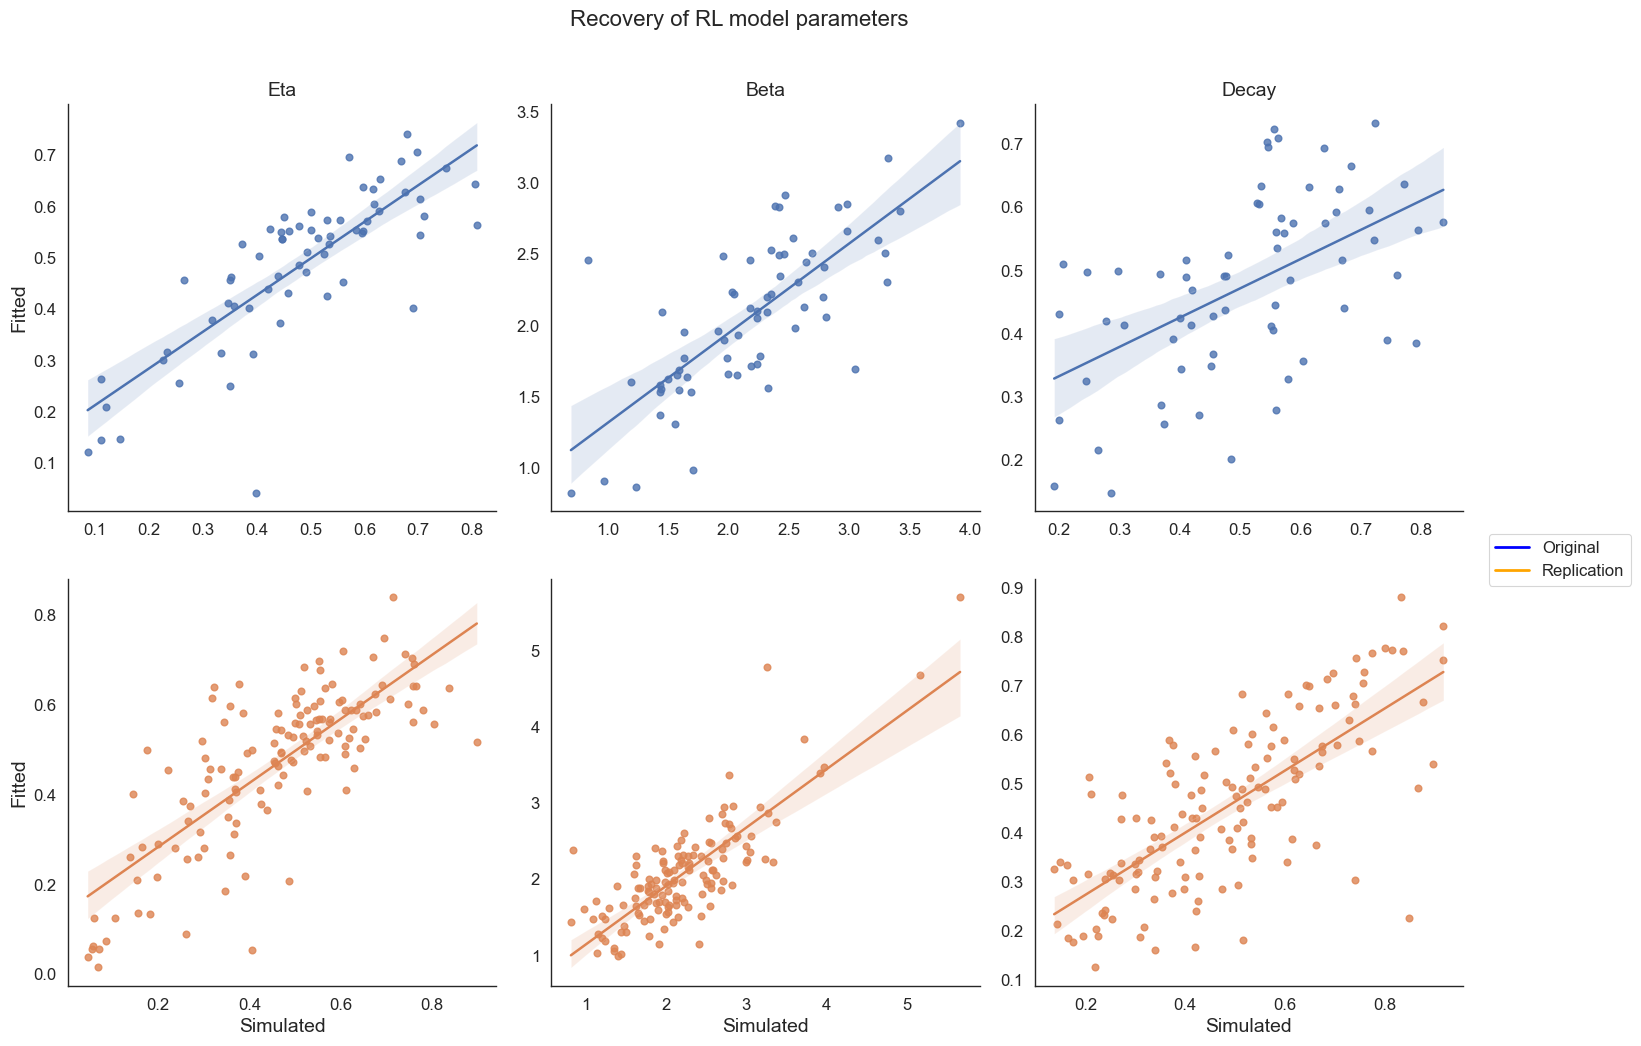

In [ ]:
g = sns.lmplot(
    x="sim",
    y="init",
    data=final_df,
    row="exp",
    col="param_name",
    sharey=False,
    sharex=False,
    hue="exp",
    col_order=["eta", "beta", "decay"],
)
g.set_axis_labels("Simulated", "Fitted", fontsize=14)
# add more space between the plots
g.tight_layout(pad=2.0)
g.axes[0, 0].set_title("Eta", fontsize=14)
g.axes[0, 1].set_title("Beta", fontsize=14)
g.axes[0, 2].set_title("Decay", fontsize=14)
g.axes[1, 0].set_title("", fontsize=14)
g.axes[1, 1].set_title("", fontsize=14)
g.axes[1, 2].set_title("", fontsize=14)

# update the tick sizes
for ax in g.axes.flatten():
    ax.tick_params(labelsize=12)

# Add custom legend
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="blue", lw=2),
    Line2D([0], [0], color="orange", lw=2),
]
g.fig.legend(
    custom_lines,
    ["Original", "Replication"],
    loc="center right",
    bbox_to_anchor=(1.1, 0.5),
    fontsize=12,
)
g.fig.suptitle("Recovery of RL model parameters", fontsize=16, y=1.05)
g.savefig(
    "../../results/figs/supplement/recovery_analysis_free_recall.png",
    dpi=300,
)

In [23]:
corr_df = pd.DataFrame()
for exp in ["exp1", "exp2"]:
    for param in ["eta", "beta", "decay"]:
        curr_df = pg.corr(
            all_fit_df[all_fit_df["exp"] == exp][f"{param}_sim"],
            all_fit_df[all_fit_df["exp"] == exp][f"{param}_init"],
            method="spearman",
        )
        curr_df["exp"] = exp
        curr_df["param"] = param
        corr_df = pd.concat([corr_df, curr_df])

In [24]:
corr_df[["n", "r", "CI95%", "p-val", "exp", "param"]]

,n,r,CI95%,p-val,exp,param
spearman,66,0.819852,"[0.72, 0.89]",3.815709e-17,exp1,eta
spearman,66,0.756268,"[0.63, 0.84]",2.098009e-13,exp1,beta
spearman,66,0.520718,"[0.32, 0.68]",7.392842e-06,exp1,decay
spearman,139,0.756361,"[0.67, 0.82]",5.011471e-27,exp2,eta
spearman,139,0.725363,"[0.64, 0.8]",5.633305e-24,exp2,beta
spearman,139,0.721618,"[0.63, 0.79]",1.233660e-23,exp2,decay


In [ ]:

fit_df = pd.read_csv(
    "../../data/processed/exp1/DecayFeatureRL_results.csv"
)
fit_df["per_trial_loglik"] = fit_df["loglik"] / 224
fit_df["prob_per_trial"] = np.exp(fit_df["per_trial_loglik"])

<Axes: >

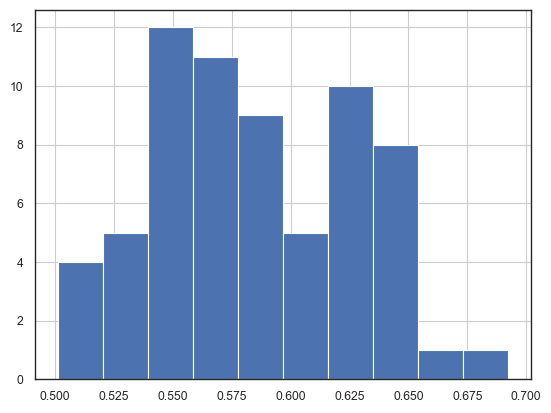

In [26]:
fit_df["prob_per_trial"].hist()

In [27]:
pg.ttest(fit_df["prob_per_trial"], 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.833474,65,two-sided,5.438982e-24,"[0.57, 0.6]",1.948966,7.356e+20,1.0
